##Imports and Initial installations

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from google.colab import drive
from pyspark.sql.types import StructField, StringType, LongType, IntegerType, ArrayType, StructType, DecimalType
from pyspark.sql import functions as F

import time
import pandas as pd

spark = SparkSession.builder.appName("Exploring the Global Job Market").config("spark.sql.session.timeZone", "America/Los_Angeles").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","12g").config("spark.sql.adaptive.enabled", "true").config("spark.sql.adaptive.coalescePartitions.enabled", "true").getOrCreate()
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


##JSON Data: 2021

In [ ]:
path_json = '/content/drive/Shareddrives/F23_CS226_DataWarehouse_18/International_Job_PostingsBig_2021/techmap-jobs-dump-2021-09.json'

schema = StructType([StructField('dateUploaded', StructType([StructField('$date', StringType(), True)]), True),
                     StructField('name', StringType(), True),
                     StructField('orgAddress', StructType([StructField('addressLine', StringType(), True), StructField('city', StringType(), True), StructField('companyName', StringType(), True), StructField('country', StringType(), True), StructField('countryCode', StringType(), True), StructField('county', StringType(), True), StructField('district', StringType(), True), StructField('formatted', StringType(), True), StructField('houseNumber', StringType(), True), StructField('level', LongType(), True), StructField('quarter', StringType(), True), StructField('state', StringType(), True), StructField('street', StringType(), True)]), True)
                     ])

df_json = spark.read.option("mode", "DROPMALFORMED").schema(schema).json(path_json)

df_json = df_json.withColumn("dateUploaded", F.col("dateUploaded.$date"))
df_json = df_json.withColumn("dateUploaded", F.date_format("dateUploaded", "yyyy-MM-dd"))
df_json = df_json.withColumn("orgAddress", F.concat_ws(', ', F.col("orgAddress.city"), F.col("orgAddress.state")))

df_json = df_json.withColumnRenamed("name", "job_title").withColumnRenamed("dateUploaded", "date_posted").withColumnRenamed("orgAddress", "job_location",)


##CSV Data 2023:

In [ ]:
csv_path_1 = '/content/drive/Shareddrives/F23_CS226_DataWarehouse_18/Linkedin_job_postings_2023/job_postings.csv'
df_csv_1 = spark.read.option("header", True).option("multiLine", True).option("mode", "DROPMALFORMED").csv(csv_path_1)
df_csv_1 = df_csv_1.drop("job_id", "company_id", "max_salary", "med_salary", "min_salary", "pay_period", "formatted_work_type", "applies", "remote_allowed", "views", "job_posting_url", "application_url", "application_type",
             "expiry", "closed_time", "formatted_experience_level", "skills_desc", "posting_domain", "sponsored", "work_type", "currency", "compensation_type", "scraped", "listed_time", "description")

df_csv_1 = df_csv_1.withColumn("original_listed_time", F.col("original_listed_time").cast(DecimalType(20, 0)))
df_csv_1 = df_csv_1.withColumn("original_listed_time", F.from_unixtime(df_csv_1["original_listed_time"] / 1000).cast("timestamp"))
df_csv_1 = df_csv_1.withColumn("original_listed_time", F.date_format("original_listed_time", "yyyy-MM-dd"))
df_csv_1 = df_csv_1.withColumnRenamed("title", "job_title").withColumnRenamed("original_listed_time", "date_posted").withColumnRenamed("location", "job_location")

df_csv_1_reordered = df_csv_1.select(["date_posted", "job_title", "job_location"])

In [ ]:
csv_path_2 = '/content/drive/Shareddrives/F23_CS226_DataWarehouse_18/International_Job_Postings_2023/allJobs.csv'
df_csv_2 = spark.read.option("header", True).option("multiLine", True).option("mode", "DROPMALFORMED").csv(csv_path_2)

df_csv_2 = df_csv_2.drop("Salary", "Job-Type", "Company", "Description")

df_csv_2 = df_csv_2.withColumnRenamed("Job-Title", "job_title").withColumnRenamed("Date-Posted", "date_posted").withColumnRenamed("Location", "job_location")

df_csv_2_reordered = df_csv_2.select(["date_posted", "job_title", "job_location"])

# df_csv_2_reordered.show()


##Combined Data

In [ ]:
df_combined = df_json.union(df_csv_1_reordered)
# print(df_combined.count())

In [ ]:
df_combined = df_combined.union(df_csv_2_reordered)
df_combined.cache()
# print(df_combined.count())

DataFrame[date_posted: string, job_title: string, job_location: string]

##SparkSQL Querying

In [ ]:
import matplotlib.pyplot as plt
start = time.time()
df_combined.createOrReplaceTempView('JobData')
CategoryBased_df = spark.sql(
'''
SELECT
    COUNT(*) AS JobCount,
    SUM(CASE
        WHEN date_posted LIKE "%2021%" THEN 1
        ELSE 0
    END) AS JobCount_2021,
    SUM(CASE
        WHEN date_posted LIKE "%2023%" THEN 1
        ELSE 0
    END) AS JobCount_2023,
    (CASE
        WHEN job_title LIKE "%Software%" THEN 'Software'
        WHEN job_title LIKE "%Data%" THEN 'Data'
        WHEN job_title LIKE "%Machine Learning%" THEN 'Machine Learning'
        WHEN job_title LIKE "%Artificial Intelligence%" THEN 'Artificial Intelligence'
        WHEN job_title LIKE "% AI %" THEN 'Artificial Intelligence'
        ELSE 'Other'
    END) AS JobCategory
FROM
    JobData
WHERE
    (job_title LIKE "%Software%" OR
    job_title LIKE "%Data%" OR
    job_title LIKE "%Machine Learning%" OR
    job_title LIKE "%Artificial Intelligence%" OR
    job_title LIKE "% AI %")
GROUP BY
    JobCategory
ORDER BY
    JobCount DESC;

'''
)
jobs = CategoryBased_df.toPandas()
end = time.time()
print(f"Time to query combined, cleaned dataframe = {(end - start)/60:.2f} minutes")

Time to query combined, cleaned dataframe = 13.12 minutes


##Analysis and Plots

In [ ]:
display(jobs)

,JobCount,JobCount_2021,JobCount_2023,JobCategory
0,51006,49848,942,Software
1,41401,39385,1639,Data
2,1593,1518,55,Machine Learning
3,443,391,35,Artificial Intelligence


<Axes: xlabel='JobCategory'>

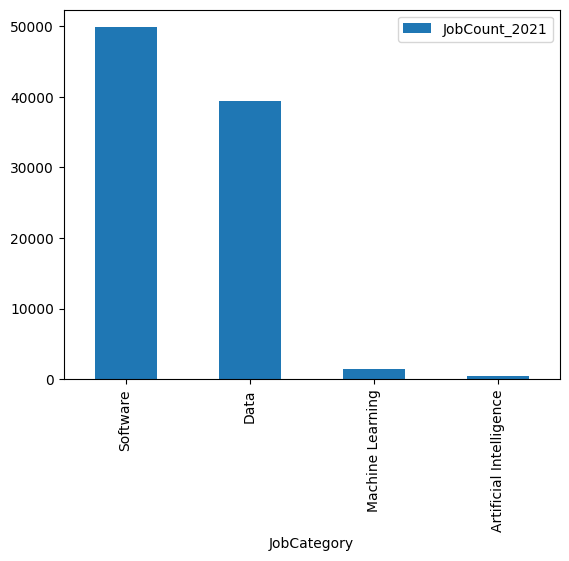

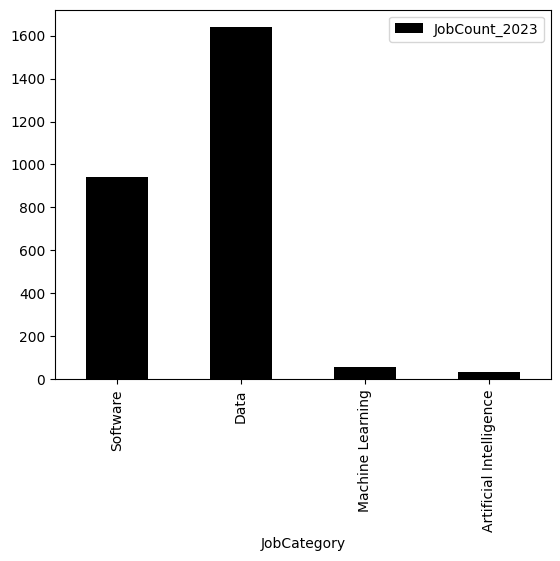

In [ ]:
jobs.plot(x="JobCategory", y=["JobCount_2021"], kind='bar')
jobs.plot(x="JobCategory", y=["JobCount_2023"], color='black', kind='bar')

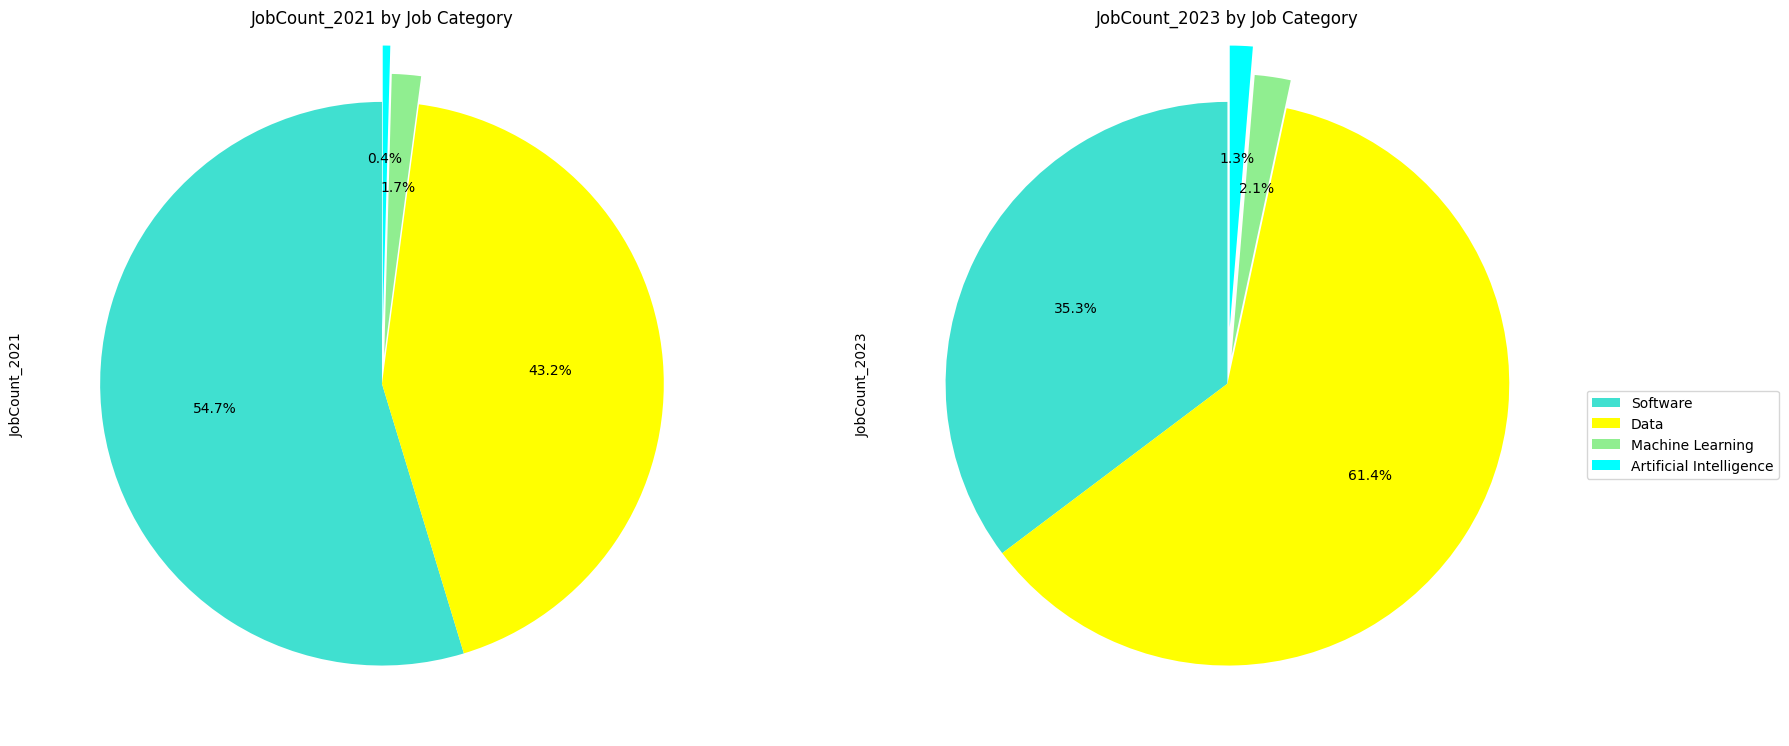

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
explode = (0, 0, 0.1, 0.2)  # explode the first slice

# Plot pie chart for JobCount_2021
jobs.plot.pie(y='JobCount_2021', autopct='%1.1f%%', startangle=90, labels=None, explode=explode, ax=axes[0], colors=['turquoise', 'yellow', 'lightgreen', 'cyan'])
axes[0].set_title('JobCount_2021 by Job Category')
axes[0].legend().set_visible(False)

# Plot pie chart for JobCount_2023
jobs.plot.pie(y='JobCount_2023', autopct='%1.1f%%', startangle=90, labels=None, explode=explode, ax=axes[1], colors=['turquoise', 'yellow', 'lightgreen', 'cyan'])
axes[1].set_title('JobCount_2023 by Job Category')
axes[1].legend(jobs['JobCategory'], loc='upper left', bbox_to_anchor=(1, 0.5))

plt.show()